In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import pandas as pd
from torch.optim import lr_scheduler

In [2]:
learning_rate = 1e-4
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
t = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0), std=(1))]
                       )

In [4]:
cifar_train = torchvision.datasets.CIFAR10(root = './CIFAR10/' , train = True , download = True , transform = t)
cifar_split = torchvision.datasets.CIFAR10(root = './CIFAR10/' , train = False , download = True , transform = t)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
torch.manual_seed(42)
cifar_val,cifar_test = random_split(cifar_split,(6700,3300))

In [6]:
train_loader = DataLoader(cifar_train,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 4)
val_loader = DataLoader(cifar_val,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)
test_loader = DataLoader(cifar_test,
                        batch_size = batch_size,
                        shuffle = False,
                        num_workers = 4)

## **Network**

In [7]:
class VGG16_encoder(nn.Module):
    def __init__(self):
        super(VGG16_encoder, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        indices = []
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x, i = self.maxpool(x)
        indices.append(i)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x, i = self.maxpool(x)
        indices.append(i)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x, i = self.maxpool(x)
        indices.append(i)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x,i = self.maxpool(x)
        indices.append(i)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x, i = self.maxpool(x)
        indices.append(i)
        #x = x.reshape(x.shape[0], -1)
        x = self.flatten(x)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        #x = F.relu(self.fc2(x))
        #x = F.dropout(x, 0.5)
        #x = self.fc3(x)
        return x ,indices

In [8]:
class VGG16_decoder(nn.Module):
    def __init__(self):
        super(VGG16_decoder, self).__init__()
        self.conv1_1 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, padding=1)
        self.conv1_2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv2_2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv3_2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.conv4_2 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.unmaxpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(512, 1, 1))
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x, indices):
    
        x = self.unflatten(x)
        x = self.unmaxpool(x, indices[-1])
        x = F.relu(self.conv5_3(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_1(x))
        
        x = self.unmaxpool(x, indices[-2])
        x = F.relu(self.conv4_3(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_1(x))
        
        x = self.unmaxpool(x, indices[-3])
        x = F.relu(self.conv3_3(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_1(x))
        
        x = self.unmaxpool(x, indices[-4])
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv2_1(x))
        
        x = self.unmaxpool(x, indices[-5])
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_1(x))

        return x

In [9]:
#test
a = torch.rand(512, 3, 32, 32)
print(a.shape)

model= VGG16_encoder()
b , indices = model(a)
print(b.shape)

decoder = VGG16_decoder()
decoder(b, indices).shape

torch.Size([512, 3, 32, 32])
torch.Size([512, 512])


torch.Size([512, 3, 32, 32])

In [10]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VGG16_encoder()
        self.decoder = VGG16_decoder()

    def forward(self, image):
        feature, indices = self.encoder(image)
        out = self.decoder(feature, indices)
        return out

In [11]:
net= AE().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

In [19]:
p = torch.distributions.Normal(0,1)
q = torch.distributions.Normal(2,4)

z = q.rsample()
print(z)

log_pz  = p.log_prob(z)
log_qzx = q.log_prob(z)

print('log prob pz: ', log_pz, 'prob:', torch.exp(log_pz))
print('log prob qzx:', log_qzx, 'prob:', torch.exp(log_qzx))

kl = log_qzx - log_pz
print('kl:', kl)
kl = kl.sum(-1)
kl

tensor(-2.5313)
log prob pz:  tensor(-4.1226) prob: tensor(0.0162)
log prob qzx: tensor(-2.9469) prob: tensor(0.0525)
kl: tensor(1.1757)


tensor(1.1757)

In [34]:
epoch_loss_train = []
epoch_loss_val = []

count = 0

len_train = len(train_loader)
len_val = len(val_loader)

#since = time.time()

for epoch in range(40):
    #train
    total_loss = 0
    for i, (img, label) in enumerate(train_loader, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer.zero_grad()
        
        embedding = net(img)
        
        
        loss = criterion(embedding, img)
    
        loss.backward()
        
        optimizer.step()
        
        
        total_loss += loss.item()
    
    epoch_loss_train.append(total_loss/len_train)
    
    #validation
    total_loss_val = 0
    for j, (img, label) in enumerate(val_loader, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer.zero_grad()
        
        embedding = net(img)
        #print(embedding.shape)
        
        loss = criterion(embedding, img)

        total_loss_val += loss.item()
    
    print(f"Epoch:{epoch} -> train loss:{total_loss/len_train} ,validation loss:{total_loss_val/len_val}")
    epoch_loss_val.append(total_loss_val/len_val)
#time_elapsed = time.time() - since

Epoch:0 -> train loss:0.04817822395735766 ,validation loss:0.010198384997839073
Epoch:1 -> train loss:0.007543952895037811 ,validation loss:0.006110608489867652
Epoch:2 -> train loss:0.005560724012305974 ,validation loss:0.005886012907930702
Epoch:3 -> train loss:0.004834601966440297 ,validation loss:0.004484745695800433
Epoch:4 -> train loss:0.004343819160781363 ,validation loss:0.004303693591248033
Epoch:5 -> train loss:0.0039758804597227314 ,validation loss:0.003757638136311522
Epoch:6 -> train loss:0.003689854854212888 ,validation loss:0.0035152152786909973
Epoch:7 -> train loss:0.00345033560962895 ,validation loss:0.0033294374588876963
Epoch:8 -> train loss:0.003348725681166972 ,validation loss:0.0031938532736363275
Epoch:9 -> train loss:0.0031184875835066714 ,validation loss:0.003048822613222138
Epoch:10 -> train loss:0.003024259265964789 ,validation loss:0.0029277331020050455
Epoch:11 -> train loss:0.0029259799411544183 ,validation loss:0.0028338969228262046
Epoch:12 -> train lo

In [44]:
PATH = 'model/model.pth'
torch.save(model.state_dict(), PATH)

In [49]:
PATH = 'model/net1.pth'
torch.save(net.state_dict(), PATH)

In [51]:
torch.save(net.state_dict(),'net/net.pth')

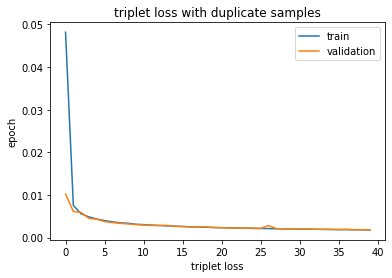

In [35]:
plt.plot(epoch_loss_train)
plt.plot(epoch_loss_val)
plt.title('triplet loss with duplicate samples')
plt.xlabel('triplet loss')
plt.ylabel('epoch')
plt.legend(['train', 'validation']);

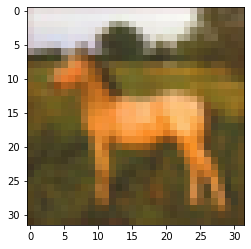

In [36]:
k = 12
plt.imshow(cifar_test[k][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


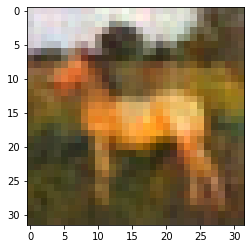

In [38]:
test = net(cifar_test[k][0].unsqueeze(0).cuda())
plt.imshow(test[0].permute(1,2,0).cpu().detach());